In [34]:
import math

import jax
import jax.numpy as jnp
import numpy as np
import optax
import skimage
from matplotlib import pyplot as plt

import chromatix as cx

In [21]:
def show_amplitude_and_phase(amplitude: np.ndarray, phase: np.ndarray):
    fig, axes = plt.subplots(nrows=1, ncols=2, dpi=300)
    ax = axes[0]
    ax.imshow(amplitude, cmap="gray", vmin=0.999, vmax=1.001)
    ax.axis("off")
    ax.set_title("amplitude")
    ax = axes[1]
    ax.imshow(phase, cmap="gray", vmin=-math.pi, vmax=math.pi)
    ax.axis("off")
    ax.set_title("phase")

In [3]:
class StructuredRandomPhaseRetrieval:
    def __init__(
        self, input_shape: tuple, output_shape: tuple, num_layers: int | float
    ):
        assert num_layers * 2 == math.floor(num_layers * 2), (
            "Number of layers must be an integer or half-integers."
        )
        assert (
            input_shape[0] == output_shape[0] and input_shape[-1] == output_shape[-1]
        ), "Batch and channel dimensions must match in input and output shapes."
        assert input_shape[1] % 2 == input_shape[2] % 2 == 0, (
            "Input shape must be square and even in width and height."
        )
        assert output_shape[1] % 2 == output_shape[2] % 2 == 0, (
            "Output shape must be square and even in width and height."
        )

        if num_layers - math.floor(num_layers) > 0:
            self.half = True
        else:
            self.half = False

        if input_shape[1] <= output_shape[1] and input_shape[2] <= output_shape[2]:
            self.mode = "oversampling"
            self.middle_shape = output_shape
        elif input_shape[1] >= output_shape[1] and input_shape[2] >= output_shape[2]:
            self.mode = "undersampling"
            self.middle_shape = input_shape
        else:
            raise ValueError(
                "Dimension changes from input to output are not consistent in width and height."
            )

        self.input_shape = input_shape
        self.output_shape = output_shape
        self.num_layers = num_layers

        self.diffuser_phases = []
        for _ in range(math.floor(num_layers)):
            self.diffuser_phases.append(2 * np.pi * np.random.rand(*self.middle_shape))

    def linear(self, x: cx.ScalarField):
        assert x.shape == self.input_shape, (
            f"Input shape {x.shape} does not match expected input shape {self.input_shape}."
        )

        if self.mode == "oversampling":
            x = cx.field.pad(
                x,
                (
                    (self.middle_shape[1] - self.input_shape[1]) // 2,
                    (self.middle_shape[2] - self.input_shape[2]) // 2,
                ),
            )

        if self.half:
            x = cx.functional.ff_lens(x, f=10, n=1.3)

        for i in range(math.floor(self.num_layers)):
            x = cx.functional.phase_change(x, self.diffuser_phases[i])
            x = cx.functional.ff_lens(x, f=10, n=1.3)

        if self.mode == "undersampling":
            x = cx.field.crop(
                x,
                (
                    (self.middle_shape[1] - self.output_shape[1]) // 2,
                    (self.middle_shape[2] - self.output_shape[2]) // 2,
                ),
            )

        return x

    def forward(self, x):
        return self.linear(x).intensity

    def adjoint(self, y):
        assert y.shape == self.output_shape, (
            f"Output shape {y.shape} does not match expected output shape {self.output_shape}."
        )

        if self.mode == "undersampling":
            y = cx.field.pad(
                y,
                (
                    (self.middle_shape[1] - self.output_shape[1]) // 2,
                    (self.middle_shape[2] - self.output_shape[2]) // 2,
                ),
            )

        for i in range(math.floor(self.num_layers) - 1, -1, -1):
            y = cx.functional.ff_lens(y, f=10, n=1.3, inverse=True)
            y = cx.functional.phase_change(y, -self.diffuser_phases[i])

        if self.half:
            y = cx.functional.ff_lens(y, f=10, n=1.3, inverse=True)

        if self.mode == "oversampling":
            y = cx.field.crop(
                y,
                (
                    (self.middle_shape[1] - self.input_shape[1]) // 2,
                    (self.middle_shape[2] - self.input_shape[2]) // 2,
                ),
            )

        return y

In [4]:
size = 128

model = StructuredRandomPhaseRetrieval(
    input_shape=(1, size, size, 1, 1),
    output_shape=(1, 2 * size, 2 * size, 1, 1),
    num_layers=2,
)

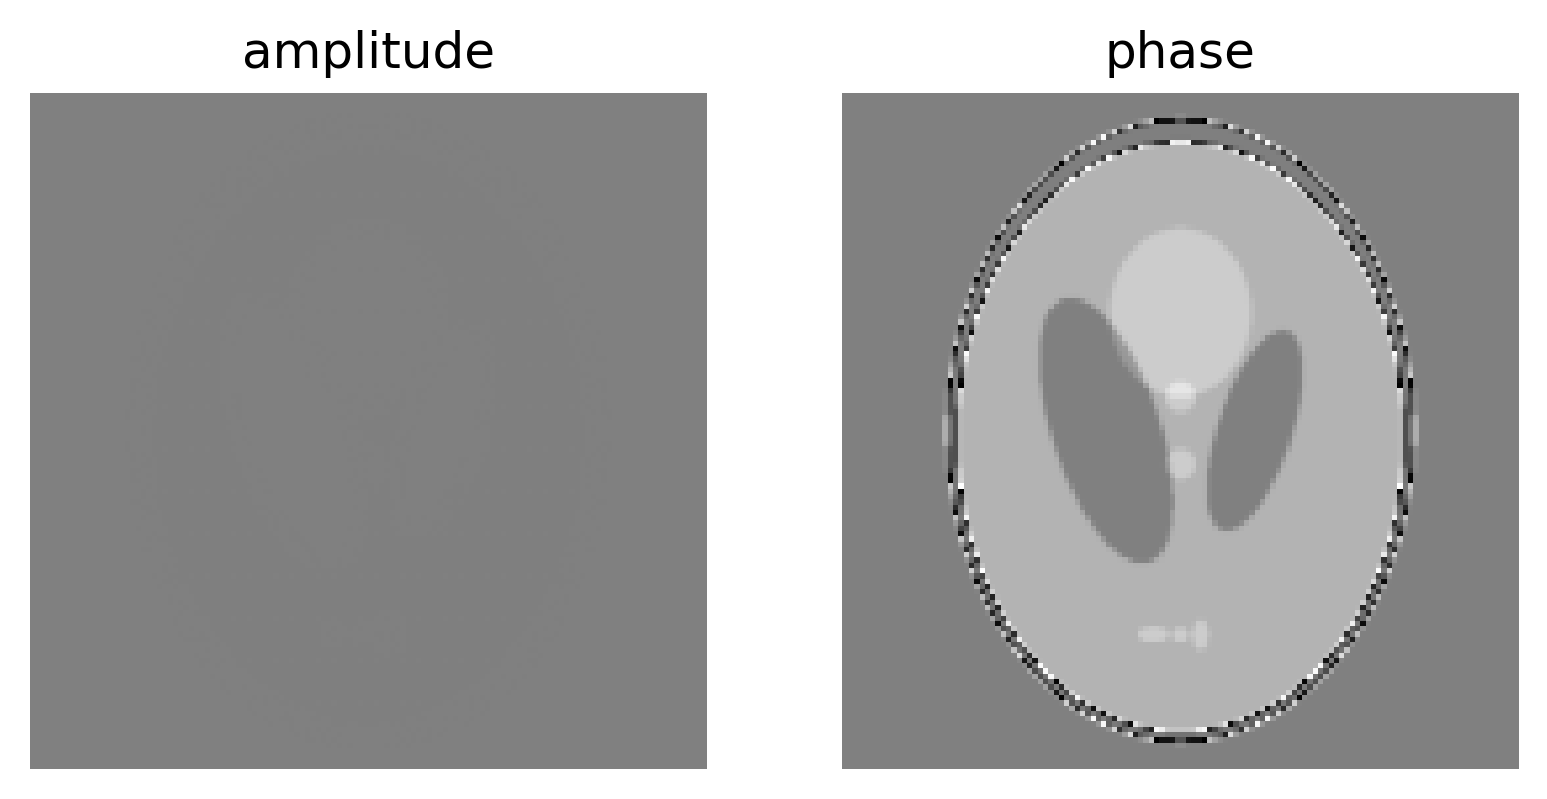

In [ ]:
phase = skimage.data.shepp_logan_phantom().astype("float")
phase = skimage.transform.resize(phase, (size, size))
phase = np.expand_dims(phase, axis=(0, -2, -1))
u = np.exp(1j * 2 * np.pi * phase)
x = cx.ScalarField.create(u=u, dx=1, spectrum=0.532, spectral_density=1.0)
show_amplitude_and_phase(np.abs(x.u[0, :, :, 0, 0]), np.angle(x.u[0, :, :, 0, 0]))

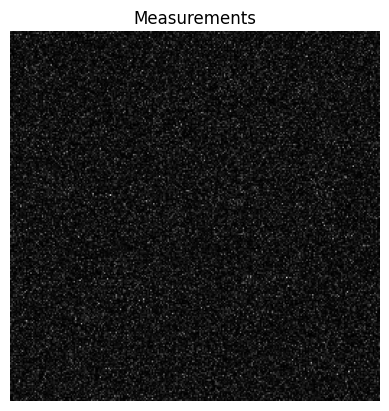

In [32]:
assert jnp.allclose(model.adjoint(model.linear(x)).u, x.u, atol=1e-5), (
    "Adjoint operation does not match original input."
)
y = model.forward(x)
plt.imshow(y[0, :, :, 0, 0], cmap="gray")
plt.axis("off")
plt.title("Measurements")
plt.show()

In [7]:
def spectral_methods(
    y,
    model: StructuredRandomPhaseRetrieval,
    num_iterations: int = 400,
    lambd: float = -5.0,
):
    """
    Perform spectral methods for phase retrieval using the structured random phase retrieval model.

    Arg s:
        y (cx.ScalarField): The observed intensity field.
        model (StructuredRandomPhaseRetrieval): The structured random phase retrieval model.
        num_iterations (int): Number of iterations for the optimization.

    Returns:
        cx.ScalarField: Reconstructed field.
    """
    x = cx.ScalarField.create(
        u=np.exp(1j * 2 * np.pi * np.random.rand(*model.input_shape)),
        dx=1,
        spectrum=0.532,
        spectral_density=1.0,
    )

    y = y / jnp.mean(y)

    amplitude_mask = jnp.maximum(1 - 1 / y, lambd)

    for _ in range(num_iterations):
        x_new = model.adjoint(
            cx.functional.amplitude_change(model.linear(x), amplitude_mask)
        )
        x_new = x_new - 2 * lambd * x
        x_new = x_new / jnp.linalg.norm(x_new.u.flatten())
        x = x_new
        # print(jnp.linalg.norm(x.u.flatten()))

    return x

In [8]:
x_hat = spectral_methods(model.forward(x), model, num_iterations=400, lambd=-5.0)

In [11]:
def cosine_similarity(x, y):
    """
    Compute the cosine similarity between two complex fields.

    Args:
        x (cx.ScalarField): First complex field.
        y (cx.ScalarField): Second complex field.

    Returns:
        float: Cosine similarity value.
    """
    ux = x.u.flatten()
    uy = y.u.flatten()
    dot_product = jnp.sum(ux * jnp.conj(uy))
    norm_x = jnp.sqrt(jnp.sum(jnp.abs(ux) ** 2))
    norm_y = jnp.sqrt(jnp.sum(jnp.abs(uy) ** 2))

    return jnp.abs(dot_product) / (norm_x * norm_y)


def correct_global_phase(x_hat, x, threshold: float = 1e-5, verbose: bool = False):
    assert x_hat.shape == x.shape, "The shapes of the images should be the same."

    n_imgs = x_hat.shape[0]
    n_channels = x_hat.shape[-2]

    for i in range(n_imgs):
        for j in range(n_channels):
            e_minus_phi = (x_hat[i, :, :, j, :].conj() * x[i, :, :, j, :]) / (
                np.abs(x[i, :, :, j, :]) ** 2
            )
            if e_minus_phi.var() < threshold:
                if verbose:
                    print(f"Image {i}, channel {j} has a constant global phase shift.")
            else:
                if verbose:
                    print(f"Image {i}, channel {j} does not have a global phase shift.")
            e_minus_phi = e_minus_phi.mean()
            x_hat.at[i, :, :, j, :].set(x_hat[i, :, :, j, :] * e_minus_phi)

    return x_hat

Cosine similarity: 0.8589034676551819


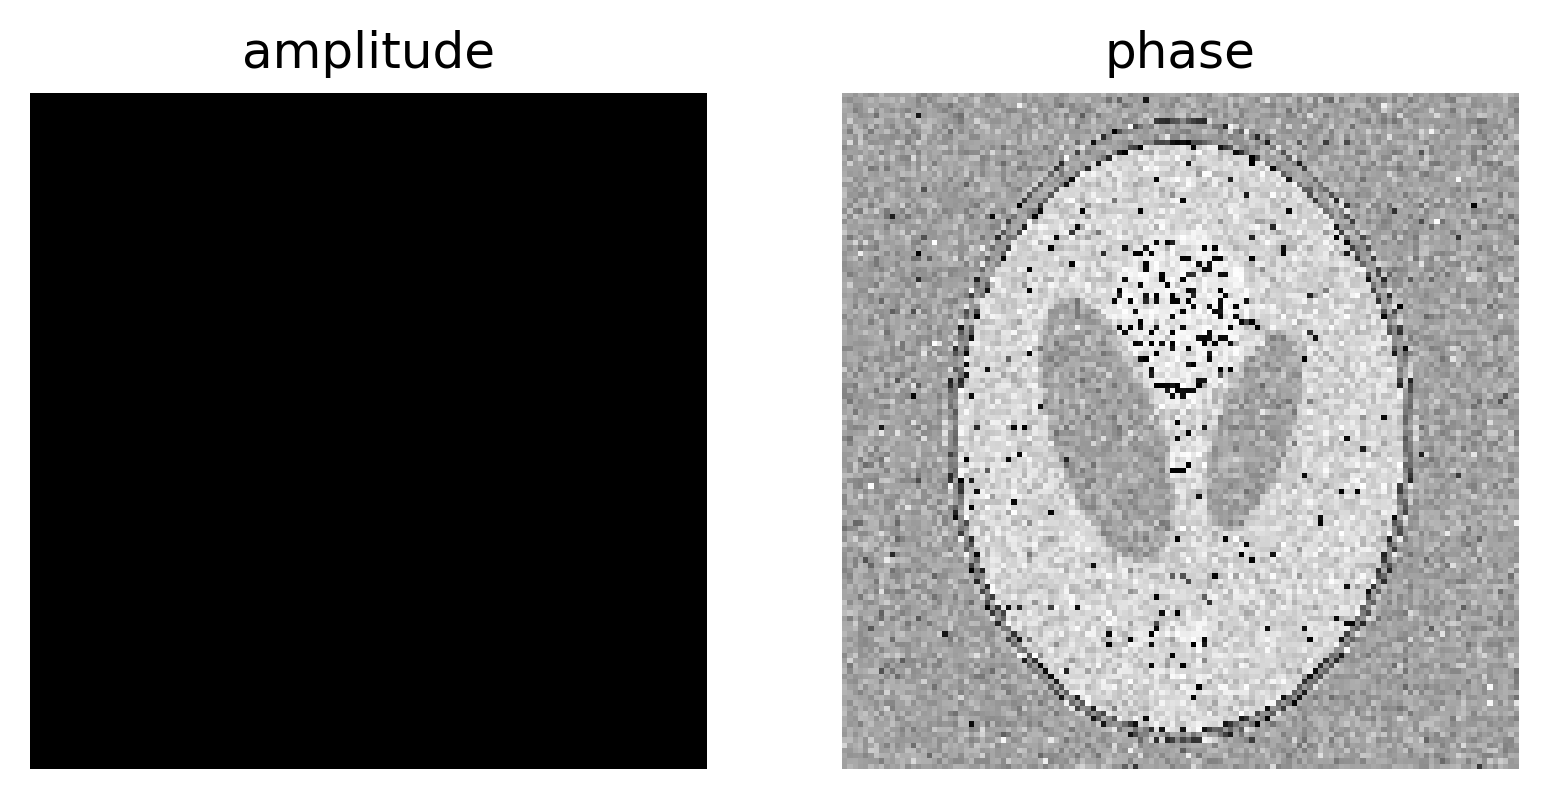

In [23]:
print("Cosine similarity:", cosine_similarity(x_hat, x).item())
final = correct_global_phase(x_hat.u, x.u, threshold=1e-5)
show_amplitude_and_phase(np.abs(final[0, :, :, :, 0]), np.angle(final[0, :, :, :, 0]))

In [138]:
parameters = x_hat
optimizer = optax.adam(1e-1)
opt_state = optimizer.init(parameters)

In [139]:
def loss_fn(parameters, measurements):
    simulated = model.forward(parameters)
    return jnp.mean((simulated - measurements) ** 2)

In [140]:
def step(parameters, opt_state, measurements):
    loss, grads = jax.value_and_grad(loss_fn)(parameters, measurements)
    updates, opt_state = optimizer.update(grads.conj, opt_state)
    parameters = optax.apply_updates(parameters, updates)
    return loss, parameters, opt_state

In [143]:
losses = []
for i in range(200):
    loss, parameters, opt_state = step(parameters, opt_state, y)
    losses.append(np.array(loss))
    print(f"iteration {i + 1} loss = {loss}")

iteration 1 loss = 7.99502322479384e-06
iteration 2 loss = 7.294036549865268e-06
iteration 3 loss = 6.6188504206365906e-06
iteration 4 loss = 5.990349563944619e-06
iteration 5 loss = 5.433051683212398e-06
iteration 6 loss = 4.951719802193111e-06
iteration 7 loss = 4.527775217866292e-06
iteration 8 loss = 4.135472863708856e-06
iteration 9 loss = 3.7611926018144004e-06
iteration 10 loss = 3.408893917367095e-06
iteration 11 loss = 3.0898797831468983e-06
iteration 12 loss = 2.809079205690068e-06
iteration 13 loss = 2.5604258553357795e-06
iteration 14 loss = 2.333036491108942e-06
iteration 15 loss = 2.1201212803134695e-06
iteration 16 loss = 1.922026740430738e-06
iteration 17 loss = 1.7422407836420462e-06
iteration 18 loss = 1.581757146595919e-06
iteration 19 loss = 1.437479681953846e-06
iteration 20 loss = 1.3050891993771074e-06
iteration 21 loss = 1.182443838843028e-06
iteration 22 loss = 1.0699974382077926e-06
iteration 23 loss = 9.686781368145603e-07
iteration 24 loss = 8.78004243531904

Cosine similarity: 0.9999998211860657


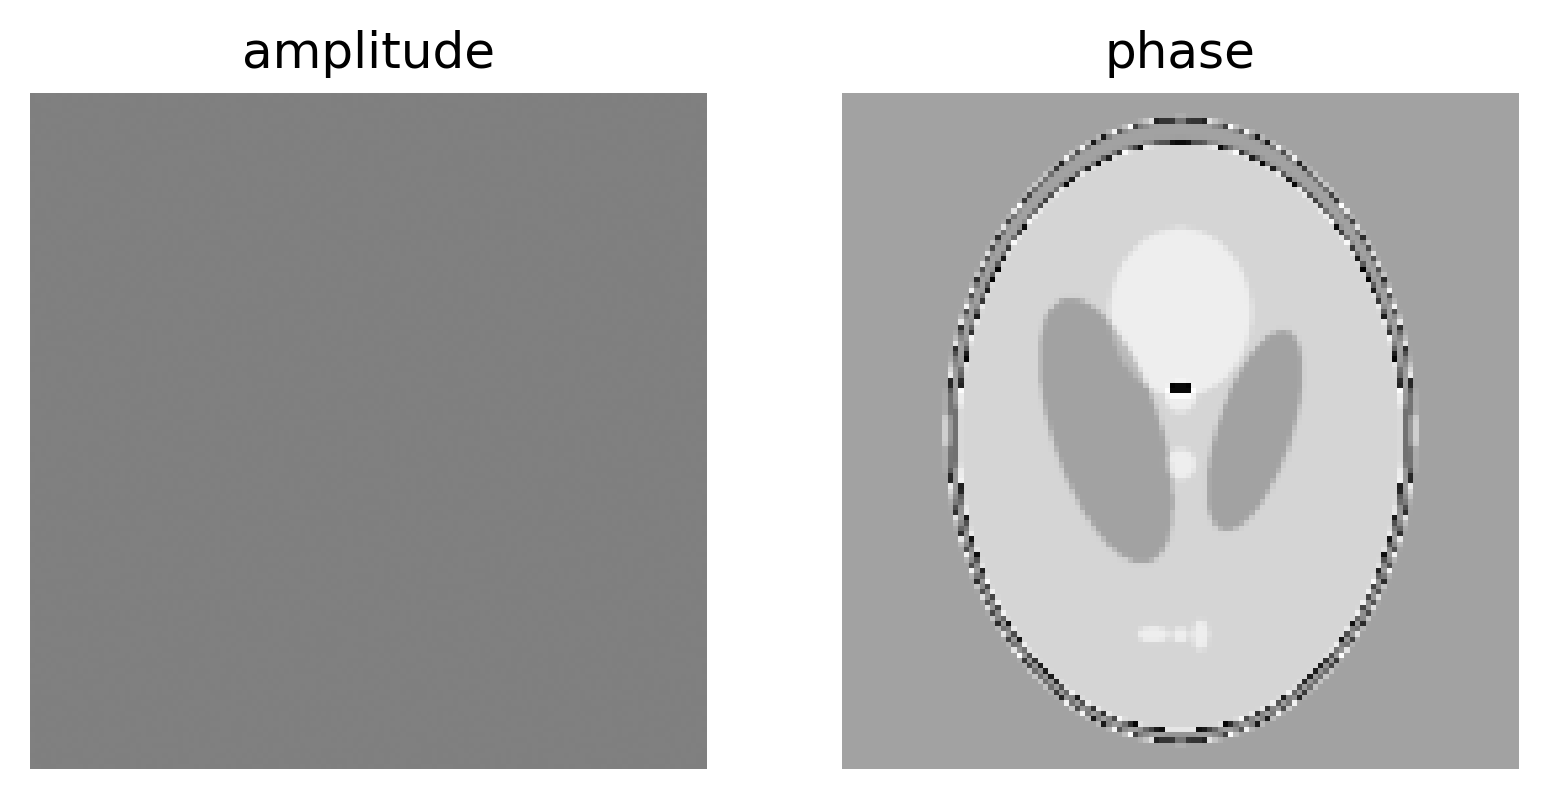

In [144]:
print("Cosine similarity:", cosine_similarity(parameters, x).item())
show_amplitude_and_phase(
    np.abs(parameters.u[0, :, :, :, 0]), np.angle(parameters.u[0, :, :, :, 0])
)